<a href="https://colab.research.google.com/github/joyfulspace/Books/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D%EC%99%84%EB%B2%BD%EA%B0%80%EC%9D%B4%EB%93%9C/ch4_2_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.3 앙상블 개요
* 앙상블: 다양한 분류기의 예측 결과를 결합하여 단일 분류기보다 신뢰성이 높은 예측값을 얻는 것. 알고리즘의 장점은 취하고 단점은 보완하면서 편향-분산 트레이드오프 효과를 극대화할 수 있음.
  - 보팅: 서로 다른 알고리즘 결합
    - 하드보팅: 다수결
    - 소프트보팅: 레이블 결정 확률을 더하고 평균내서 가장 높은 값으로 레이블 결정
  - 배깅: 같은 알고리즘에 데이터 샘플링을 다르게 보팅. ex) Random Forest
    - 데이터 샘플링: 부트스트래핑 방법. 데이터 중첩 허용.
  - 부스팅: 여러 개 분류기를 순차적으로 학습. 앞에서 예측이 틀린 데이터에 가중치 부여. ex) 그래디언트 부스트, XGBoost, LightGBM
  - 스태킹: 여러 다른 모델의 예측 결과값을 다시 학습 데이터로 만들어 다른 모델로 재학습

In [5]:
!git clone https://github.com/joyfulspace/Books.git

Cloning into 'Books'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 118 (delta 33), reused 33 (delta 6), pack-reused 0
Receiving objects: 100% (118/118), 59.10 MiB | 6.56 MiB/s, done.
Resolving deltas: 100% (33/33), done.
Checking out files: 100% (44/44), done.


In [4]:
Path = '/content/Books/파이썬머신러닝완벽가이드/data'

### Voting Classifier

In [6]:
import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [7]:
# 개별 모델을 로지스틱 회귀와 KNN.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier(estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft')

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
  classifier.fit(X_train, y_train)
  pred = classifier.predict(X_test)
  class_name = classifier.__class__.__name__
  print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))


Voting 분류기 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


## 4.4 Random Forest

In [8]:
def get_new_feature_name_df(old_feature_name_df):
  feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),
                                columns=['dup_cnt'])
  feature_dup_df = feature_dup_df.reset_index()
  new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
  new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                        if x[1] >0 else x[0] ,  axis=1)
  new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
  return new_feature_name_df

In [9]:
import pandas as pd

def get_human_dataset( ):
  
  # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
  feature_name_df = pd.read_csv(f'{Path}/human_activity/features.txt',sep='\s+',
                      header=None,names=['column_index','column_name'])
  
  # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame생성. 
  new_feature_name_df = get_new_feature_name_df(feature_name_df)
  
  # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
  feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
  
  # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
  X_train = pd.read_csv(f'{Path}/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
  X_test = pd.read_csv(f'{Path}/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
  
  # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
  y_train = pd.read_csv(f'{Path}/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
  y_test = pd.read_csv(f'{Path}/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
  
  # 로드된 학습/테스트용 DataFrame을 모두 반환 
  return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_human_dataset()

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


In [10]:
# 랜덤 포레스트 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],  # 결정 트리의 개수.
    'max_depth':[6, 8, 10, 12],
    'min_samples_leaf':[8, 12, 18],
    'min_samples_split':[8, 16, 20]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1) # n_jobs=-1이면 모든 CPU 코어 사용
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [11]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16,
                                 min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9260


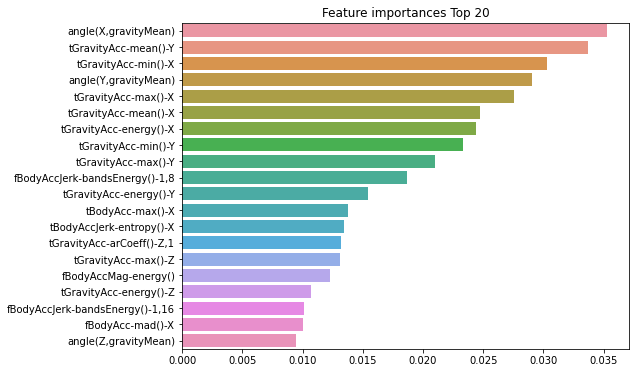

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

## 4.5 GBM(Gradient Boosting Machine)

In [13]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간: {0:.1f} 초'.format(time.time() - start_time))

GBM 정확도: 0.9386
GBM 수행 시간: 914.0 초


In [ ]:
# GBM 하이퍼 파라미터 튜닝.
# GBM 학습속도가 저하되어 참고용으로만 사용.
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500], # weak learner의 개수
    'learning_rate':[0.05, 0.1]
    # loss: 경사 하강법에 사용할 비용 함수
    # subsample: weak learner가 학습에 사용하는 데이터 샘플링 비율
}
grid_cv = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1)
grid_cv.fit(X_train, y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

In [ ]:
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

## 4.6 XGBoost
* 장점
  1. 뛰어난 예측 성능
  2. GBM 대비 빠른 수행시간
  3. 과적합 규제 (GBM은 없음)
  4. Tree pruning(나무 가지치기): 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄임
  5. 자체 내장된 교차 검증: 반복 수행 시마다 교차 검증 수행해 최적화된 반복 수행 횟수 가짐. 조기 중단 기능도 있음
  6. 결손값 자체 처리

### 위스콘신 유방암 예측

In [18]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [19]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [20]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size=0.2, random_state=156)

# 학습용 데이터를 다시 학습, 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)
print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [21]:
# 학습, 검증, 테스트용 DMarix 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [22]:
params = {'max_depth':3,
          'eta':0.05, # 학습률. XGBClassifier 사용하면 learning_rate
          'objective':'binary:logistic', # 목적함수
          'eval_metric':'logloss' # 오류 함수의 평가 성능 지표
}
num_rounds = 400 # 부스팅 반복 횟수

In [21]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'
eval_list = [(dtr, 'train'), (dval, 'eval')]

# 하이퍼 파라미터와 early stopping 파라미터 전달
# early_stopping_rounds: 최고 성능에서 50번 더 확인하고 성능이 향상되지 않으면 stop
xgb_model = xgb.train(params=params, dtrain=dtr, num_boost_round=num_rounds,
                      early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.650163	eval-logloss:0.661831
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.611313	eval-logloss:0.636086
[2]	train-logloss:0.575629	eval-logloss:0.611436
[3]	train-logloss:0.543102	eval-logloss:0.592036
[4]	train-logloss:0.513233	eval-logloss:0.573291
[5]	train-logloss:0.484475	eval-logloss:0.550371
[6]	train-logloss:0.457959	eval-logloss:0.529295
[7]	train-logloss:0.434357	eval-logloss:0.51534
[8]	train-logloss:0.411503	eval-logloss:0.497179
[9]	train-logloss:0.390274	eval-logloss:0.481542
[10]	train-logloss:0.371284	eval-logloss:0.469904
[11]	train-logloss:0.352541	eval-logloss:0.45474
[12]	train-logloss:0.335277	eval-logloss:0.442294
[13]	train-logloss:0.318925	eval-logloss:0.429608
[14]	train-logloss:0.304394	eval-logloss:0.42065
[15]	train-logloss:0.289996	eval-logloss:0.409577
[16]	train-logloss:0.276514	eval-logloss:0.398867
[17]	train-log

In [22]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [24]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


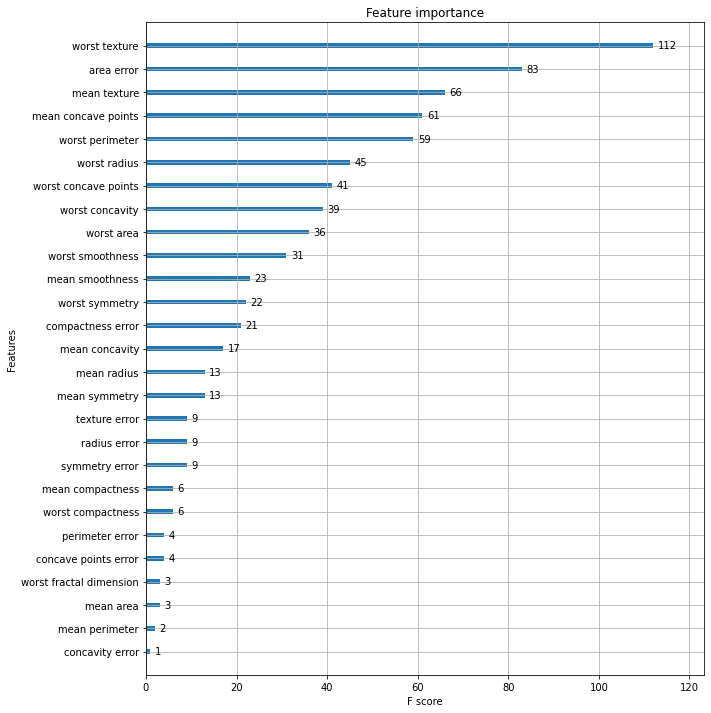

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_mportance.tif', format='tif', dpi=300, bbox_inches='tight')

In [28]:
# 사이킷런 래퍼
from xgboost import XGBClassifier

evals = [(X_test, y_test)]
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_set=evals,
                eval_metric='logloss', verbose=True)
# 조기중단 관련 파라미터: early_stopping_rounds, eval_metric, eval_set
# eval_metric: 조기 중단을 위한 평가 지표
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

In [29]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [30]:
# early_stopping_rounds를 10으로 설정하고 재학습
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
                eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


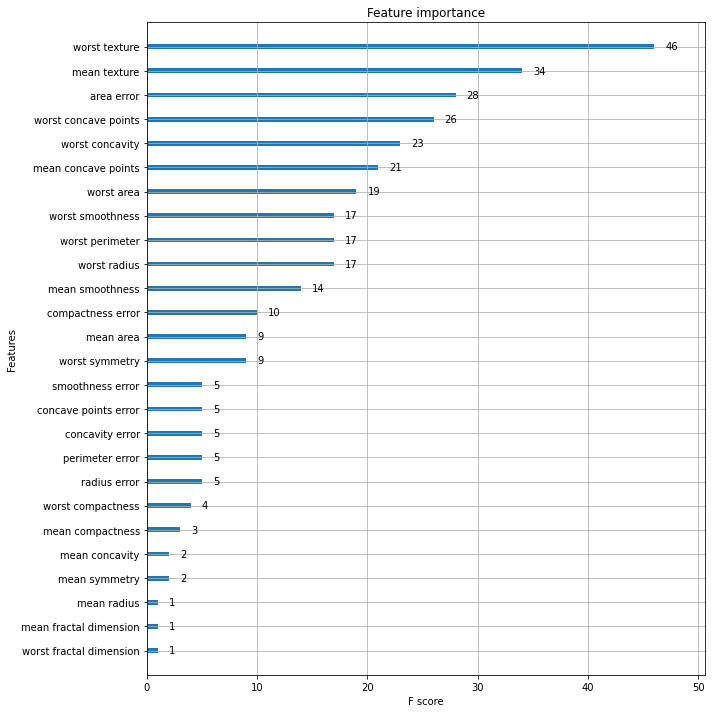

In [31]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)

## 4.7 LightGBM
* 장점: XGBoost와 비슷한 성능을 가지면서 수행 시간이 훨씬 적음. 카테고리형 변수의 자동 변환, 최적 분할
* 단점: 적은 데이터에서 과적합 발생 쉬움(10,000건 이하)
* 특징: 일반 GBM 계열의 트리 분할 방법과 다르게 리프 중심 트리 분할 방식 사용.
  - 기존 알고리즘: 균형 트리 분할 방식(Level Wise). 트리 깊이 최소화. 오버피팅에 강한 구조. 균형 맞추기 위한 시간 필요.
  - LightGBM: 리프 중심 트리 분할 방식(Leaf Wise). 최대 손실 값을 가지는 리프 노드를 지속적으로 분할. 트리 깊어지고 비대칭적 규칙 트리 생성. 학습을 반복할수록 예측 오류 손실을 최소화할 수 있다는 생각.

In [2]:
import lightgbm
print(lightgbm.__version__)

2.2.3


In [24]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target'] = dataset.target
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_Test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2,random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정.
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	training's binary_logloss: 0.625671	training's binary_logloss: 0.625671	valid_1's binary_logloss: 0.628248	valid_1's binary_logloss: 0.628248
Training until validation scores don't improve for 50 rounds.
[2]	training's binary_logloss: 0.588173	training's binary_logloss: 0.588173	valid_1's binary_logloss: 0.601106	valid_1's binary_logloss: 0.601106
[3]	training's binary_logloss: 0.554518	training's binary_logloss: 0.554518	valid_1's binary_logloss: 0.577587	valid_1's binary_logloss: 0.577587
[4]	training's binary_logloss: 0.523972	training's binary_logloss: 0.523972	valid_1's binary_logloss: 0.556324	valid_1's binary_logloss: 0.556324
[5]	training's binary_logloss: 0.49615	training's binary_logloss: 0.49615	valid_1's binary_logloss: 0.537407	valid_1's binary_logloss: 0.537407
[6]	training's binary_logloss: 0.470108	training's binary_logloss: 0.470108	valid_1's binary_logloss: 0.519401	valid_1's binary_logloss: 0.519401
[7]	training's binary_logloss: 0.446647	training's binary_loglos

In [25]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9888


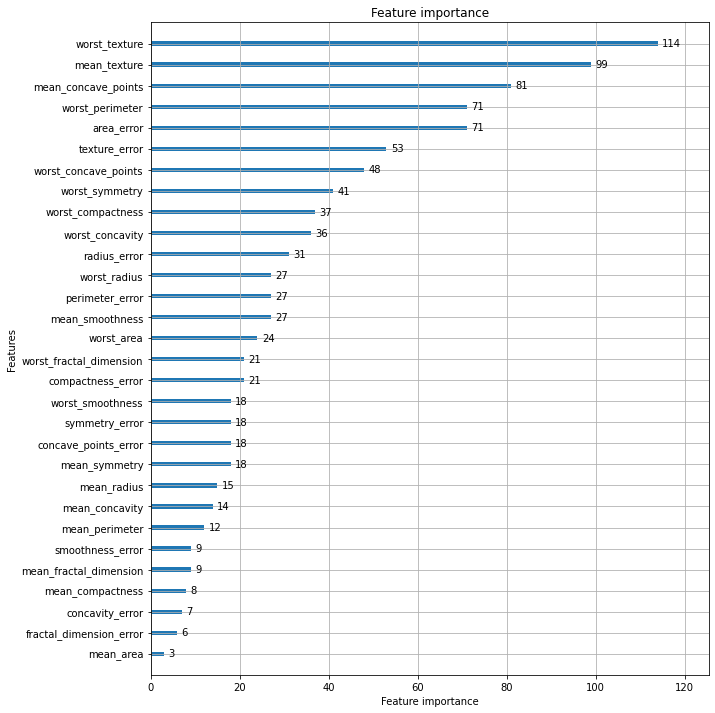

In [26]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
plt.savefig('lightgbm_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

## 4.8 베이지안 최적화 기반 HyperOpt 이용한 하이퍼 파라미터 튜닝
* 베이지안 최적화: 목적 함수 식을 제대로 알 수 없는 경우 최적 입력값을 찾아주는 방식.
  - 새로운 데이터를 입력받았을 때 최적 함수를 예측하는 사후 모델을 개선해 나가면서 최적 함수 모델 만듬.
  - 대체 모델: 획득 함수로부터 최적 함수를 예측할 수 있는 입력값 추천받아 이를 기반으로 최적 함수 모델 개선.
  - 획득 함수: 개선된 대체 모델을 기반으로 최적 입력값 을 계산.

* 베이지안 최적화를 머신러닝 모델의 하이퍼 파라미터 튜닝에 적용.


In [11]:
import hyperopt
print(hyperopt.__version__)

0.2


In [12]:
from hyperopt import hp

# -10 ~ 10까지 1간격을 가지는 입력 변수 x와 -15 ~ 15까지 1간격으로 입력분수 y 설정
search_space = {'x':hp.quniform('x', -10, 10, 1), 
                'y':hp.quniform('y', -15, 15, 1)}

In [13]:
from hyperopt import STATUS_OK

# 목적 함수를 생성.
def objective_func(search_space):
  x = search_space['x']
  y = search_space['y']
  retval = x**2 - 20*y
  return retval

In [14]:
from hyperopt import fmin, tpe, Trials
import numpy as np

# 입력 결괏값을 저장한 Trials 객체값 생성.
trial_val = Trials()

# 목적 함수의 최솟값을 반환하는 최적 입력 변숫값을 5번의 입력값 시도(max_evals=5)로 찾아냄.
best_01 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=5
               , trials=trial_val, rstate=np.random.RandomState(seed=0))
print('best:', best_01)
# 목적함수와 설정한 x, y 범위에 따르면 x는 0, y는 15에 가까울 수록 반환값 최고가 됨

100%|██████████| 5/5 [00:00<00:00, 406.74it/s, best loss: -4.0]
best: {'x': 4.0, 'y': 1.0}


In [15]:
trial_val = Trials()

# max_evals를 20로 늘려서 재테스트
best_02 = fmin(fn=objective_func, space=search_space, algo=tpe.suggest, max_evals=20
               , trials=trial_val, rstate=np.random.RandomState(seed=0))
print('best:', best_02)

100%|██████████| 20/20 [00:00<00:00, 581.37it/s, best loss: -264.0]
best: {'x': 6.0, 'y': 15.0}


In [27]:
# fmin()에 인자로 들어가는 Trials 객체의 result 속성에 목적 함수 반환값 저장
# 리스트 내부의 개별 원소는 {'loss':함수 반환값, 'status':반환상태값} 같은 딕셔너리
print(trial_val.results)

[{'loss': 16.0, 'status': 'ok'}, {'loss': -4.0, 'status': 'ok'}, {'loss': 240.0, 'status': 'ok'}, {'loss': 61.0, 'status': 'ok'}, {'loss': 256.0, 'status': 'ok'}, {'loss': 185.0, 'status': 'ok'}, {'loss': -100.0, 'status': 'ok'}, {'loss': -255.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': 304.0, 'status': 'ok'}, {'loss': 81.0, 'status': 'ok'}, {'loss': -19.0, 'status': 'ok'}, {'loss': 60.0, 'status': 'ok'}, {'loss': 109.0, 'status': 'ok'}, {'loss': 1.0, 'status': 'ok'}, {'loss': 240.0, 'status': 'ok'}, {'loss': -264.0, 'status': 'ok'}, {'loss': -124.0, 'status': 'ok'}, {'loss': 169.0, 'status': 'ok'}, {'loss': 4.0, 'status': 'ok'}]


In [28]:
print(trial_val.vals)

{'x': [4.0, 4.0, 10.0, -9.0, 6.0, -5.0, 10.0, 5.0, 1.0, 8.0, -1.0, 1.0, -10.0, -7.0, -9.0, 0.0, 6.0, 4.0, -7.0, 2.0], 'y': [-0.0, 1.0, -7.0, 1.0, -11.0, -8.0, 10.0, 14.0, 0.0, -12.0, -4.0, 1.0, 2.0, -3.0, 4.0, -12.0, 15.0, 7.0, -6.0, -0.0]}


In [29]:
import pandas as pd

# results에서 loss 키값에 해당하는 밸류들을 추출하여 list로 생성
losses = [loss_dict['loss'] for loss_dict in trial_val.results]

result_df = pd.DataFrame({'x':trial_val.vals['x'],
                          'y':trial_val.vals['y'],
                          'losses':losses})
result_df

,x,y,losses
0,4.0,-0.0,16.0
1,4.0,1.0,-4.0
2,10.0,-7.0,240.0
3,-9.0,1.0,61.0
4,6.0,-11.0,256.0
5,-5.0,-8.0,185.0
6,10.0,10.0,-100.0
7,5.0,14.0,-255.0
8,1.0,0.0,1.0
9,8.0,-12.0,304.0


### HyperOpt를 이용한 XGBoost 하이퍼 파라미터 최적화

In [30]:
from hyperopt import hp

# max_depth는 5에서 20까지 1간격으로, min_child_weight는 1에서 2까지 1간격으로
# colsample_bytree는 0.5에서 1사이, learning_rate는 0.01에서 0.2 사이 정규 분포된 값으로 검색
xgb_search_space = {'max_depth':hp.quniform('max_depth', 5, 20, 1),
                    'min_child_weight':hp.quniform('min_child_weight', 1, 2, 1),
                    'learning_rate':hp.uniform('learning_rate', 0.01, 0.2),
                    'colsample_bytree':hp.uniform('colsample_bytree', 0.5, 1)
                    }

In [38]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from hyperopt import STATUS_OK

# fmin()에서 입력된 search_space 값으로 입력된 모든 값은 실수형임.
# XGBClassifier의 정수형 하이퍼 파라미터는 정수형 변환을 해줘야 함.
# 정확도는 높을수록 더 좋은 수치임. -1 * 정확도를 곱해서 큰 정확도 값일수록 최소가 되도록 변환
def objective_func(search_space):
  # 수행 시간 절약을 위해 nestimators는 100으로 축소
  xgb_clf = XGBClassifier(n_estimators=100, max_depth=int(search_space['max_depth']),
                          min_child_weight=int(search_space['min_child_weight']),
                          learning_rate=search_space['learning_rate'],
                          colsample_bytree=search_space['colsample_bytree'],
                          eval_metric='logloss')
  accuracy = cross_val_score(xgb_clf, X_train, y_train, scoring='accuracy', cv=3)
  
  # accuracy는 cv=3 개수만큼 roc-auc 결과를 리스트로 가짐. 이를 평균해서 반환하되 -1을 곱함.
  return {'loss':-1 * np.mean(accuracy), 'status': STATUS_OK}

In [39]:
from hyperopt import fmin, tpe, Trials

trial_val = Trials()
best = fmin(fn=objective_func, space=xgb_search_space, 
            algo=tpe.suggest,
            max_evals=50, # 최대 반복 횟수
            trials=trial_val, 
            rstate=np.random.RandomState(seed=9))
print('best:',best)

100%|██████████| 50/50 [00:09<00:00,  5.29it/s, best loss: -0.9670762170326479]
best: {'colsample_bytree': 0.5811103711796605, 'learning_rate': 0.15180675941399624, 'max_depth': 8.0, 'min_child_weight': 1.0}


In [40]:
print('colsample_bytree:{0}, learning_rate:{1}, max_depth:{2}, min_child_weight:{3}'.format(
    round(best['colsample_bytree'], 5), round(best['learning_rate'], 5),
    int(best['max_depth']), int(best['min_child_weight'])))

colsample_bytree:0.58111, learning_rate:0.15181, max_depth:8, min_child_weight:1


In [41]:
xgb_wrapper = XGBClassifier(n_estimators=400,
                            learning_rate=round(best['learning_rate'], 5),
                            max_depth=int(best['max_depth']),
                            min_child_weight=int(best['min_child_weight']),
                            colsample_bytree=round(best['colsample_bytree'], 5)
                           )

evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric='logloss',
                eval_set=evals, verbose=True)

preds = xgb_wrapper.predict(X_test)
pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, preds, pred_proba)

[0]	validation_0-logloss:0.567035	validation_1-logloss:0.609603
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.475038	validation_1-logloss:0.557426
[2]	validation_0-logloss:0.40161	validation_1-logloss:0.496224
[3]	validation_0-logloss:0.341595	validation_1-logloss:0.44826
[4]	validation_0-logloss:0.292806	validation_1-logloss:0.422711
[5]	validation_0-logloss:0.251729	validation_1-logloss:0.392976
[6]	validation_0-logloss:0.217972	validation_1-logloss:0.364036
[7]	validation_0-logloss:0.190997	validation_1-logloss:0.342218
[8]	validation_0-logloss:0.168602	validation_1-logloss:0.322349
[9]	validation_0-logloss:0.147799	validation_1-logloss:0.305646
[10]	validation_0-logloss:0.130454	validation_1-logloss:0.29242
[11]	validation_0-logloss:0.116911	validation_1-logloss:0.283735
[12]	validation_0-logloss:0.104324	validation_1-logloss:0.273077
[13